# Tappy Keystroke Data with Parkinson’s Patients

Il task dell'analisi del dataset Tappy Keystroke è una classificazione binaria sui dati acquisiti da Tappy, un'applicazione per la registrazione delle sequenze di battitura.

Nel progetto verrà analizzato un dataset contenente i registri delle sequenze di tasti raccolti da oltre 200 soggetti, con e senza il morbo di Parkinson, che hanno digitato normalmente sul proprio computer per un periodo di settimane o mesi, senza supervisione.

L'analisi si compone di una parte di acquisizione e pulizia dei dati, e di un'altra parte per l'utilizzo di modelli di machine learning, che hanno lo scopo di indicare che l'interazione con la tastiera può essere usata per rilevare particolarità nel movimento delle dita nelle prime fasi del morbo di Parkinson.

Il dataset è stato scaricato dal link https://www.kaggle.com/datasets/valkling/tappy-keystroke-data-with-parkinsons-patients. È suddiviso a sua volta in due dataset: il primo è fornito direttamente dal software Tappy, quindi include dati come tempo di pressione e rilascio dei tasti e movimenti ottenuti dividendo virtualmente la tastiera in una zona di destra e una di sinistra; il secondo contiene informazioni sui pazienti (quali anno di nascita, sesso, e attributi riguardanti il morbo di Parkinson qualora il paziente ne fosse affetto). Tra questi, l'attributo più importante è "Parkinsons", che verrà usata come predizione per la classificazione binaria.

## Versione 2
In questa versione l'elemento che viene preso in considerazione per la classificazione è il **singolo utente**.

In particolare vengono calcolate media, deviazione standard, skewness e kurtosis, per ogni utente, per la feature TapPosition (escludendo i tap con valore S, in quanto non aggiungono informazione) usando i tempi di Hold.
Poi viene fatta la stessa cosa per la feature Movement, rispetto ai tempi di Latency (anche qui non si considerano i valori contenenti S).

## Indice

### • Set iniziale di feature

### • Caricamento dataset
- Pulizia dataset
- Feature selection
- Individuazione e rimozione degli outliers

### • Preprocessing
- Train e Test
- Scaling
- Bilanciamento

### • Classificazione
- Naive Bayes
- Logistic Regression
- Decision Tree
- Random Forest
- Multiple Layer Perceptron
- Adaboost
- SVM
- K-Nearest Neighbors
- Ensemble Voting

### • Considerazioni v2

### Set iniziale di features
Come accennato sopra, per ogni utente si hanno a disposizione due insiemi di informazioni: il primo, contenuto in un file chiamato *user_idutente* associato a ogni utente tramite il suo identificativo, con delle caratteristiche legate alla malattia; il secondo, contenuto in più file chiamati *idutente_data*, con le caratteristiche legate alla pressione dei singoli tasti.

I file *user_idutente* sono del tipo:
* BirthYear:      xxxx
* Gender:         M/F
* Parkinsons:     se all'utente è stato diagnosticato il morbo di Parkinson
* Tremors:        se l'utente ha tremori alle mani
* DiagnosisYear:  eventuale anno di diagnosi della malattia
* Sided:          lateralità della malattia
* UPDRS:          Unified Parkinson's Disease Rating Scale
* Impact:         stato di avanzamento della malattia
* Levadopa:       se l'utente assume o meno il farmaco Levadopa
* DA:             se l'utente assume o meno il farmaco Dopamine Agonist
* MAOB:           se l'utente assume o meno il farmaco MAO-B inhibitor
* Other:          se l'utente assume o meno il farmaco altri farmaci

I file *idutente_data* sono organizzati in colonne il cui significato, da sinistra a destra è:
* identificativo del paziente
* data di acquisizione
* ora di acquisizione
* zona della tastiera in cui si trova il tasto premuto
* tempo di pressione (hold)
* sequenza del tasto attuale e il precedente (movement)
* distanza temporale tra la digitazione attuale e la precedente (latency)
* latency - hold (flight time)

Questa quantità di dati iniziali verrà poi sottoposta a processi di feature selection e feature extraction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.stats import skew, kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix

### Caricamento dataset
Dopo aver creato due DataFrame a partire dai dati di Kaggle, questi vengono uniti tramite *merge* per creare un DataFrame intero, che sarà il punto di partenza del processamento dei dati.

In particolare, si sono associate ad ogni riga dei file *idutente_data* (ovvero ad ogni tap) le informazioni contenute nei file *user_idutente*, eseguendo un merge proprio sull'id utente.

In [2]:
# Creation of user_df, a DataFrame with informations about Archived Users

users = []

for filepath in glob.iglob('Users/Archived users/*.txt'):
    users.append(filepath[-14:-4])

user_number = len(users)    # number of users

user_df = pd.DataFrame(users, columns = ["Users"])

# Create columns

col_index = []

file = open('Users/Archived users/User_' + str(users[0]) + ".txt")
lines = file.read().split("\n")
ll = len(lines)

for l in range(ll-1):
    sl = lines[l].split(": ", 1)
    col_index.append(sl[0])

# Create values

values_list = []
values = []

for i in range(user_number):
    file = open('Users/Archived users/User_' + str(users[i]) + ".txt")
    lines = file.read().split("\n")
    for l in range(ll-1):
        sl = lines[l].split(": ", 1)
        v = sl[1]
        values.append(v)
    values_list.append(values)
    values = []

# Insert values in user_df

value_df = pd.DataFrame(values_list, columns = col_index)

user_df = pd.concat([user_df, value_df], axis = 1)

# Creation of tappydata_df, a DataFrame with informations about Archived Data

tappydata = []

for filepath in glob.iglob('Data/Tappy Data/*.txt'):
    file = open(filepath)
    lines = file.read().split("\n")
    for l in range(len(lines)-1):
        x = lines[l]
        x = x.split("\t")
        tappydata.append(x)

tappydata_df = pd.DataFrame(tappydata, columns = ["Users", "Date", "Datetime", "TapPosition", "Hold", "Movement", "Latency", "Flight", "*"])

# Merge user_df with tappydata_df, joining on the attribute "Users"

all_userdata_df = pd.merge(tappydata_df, user_df, how='inner', left_on='Users', right_on='Users')

#### Pulizia dataset

In una prima fase di scrematura delle informazioni a nostra disposizione, sono state effettuate delle scelte riguardo quali utenti considerare nel nostro processo di addestramento e quali no. Prima di analizzare in dettaglio tali scelte, è opportuno specificare che queste sono state dettate dalla volontà di dare maggiore credibilità alla predizione.

In primo luogo, tra i pazienti a cui è stato diagnosticato il morbo di Parkinson sono stati tenuti in considerazione solo quelli la cui malattia si trova in uno stato primordiale. A tal proposito sono stati mantenuti solo i pazienti con campo impact di valore _mild_, oltre a quelli non malati. Proseguendo in questa direzione sono stati eliminati dall'analisi anche i pazienti che assumevano Levadopa, poiché, tendenzialmente, se un paziente è affetto dalla malattia in uno stato non grave, non gli viene somministrato tale farmaco.

Una decisione di carattere più tecnico è stata quella di rimuovere i pazienti di cui sono stati collezionati troppi o troppi pochi dati di digitazione, con lo scopo di avere un insieme di dati più consistente e bilanciato.

#### Feature selection
In una seconda fase di organizzazione delle informazioni si è ritenuto opportuno eliminare alcune feature che risultavano meno utili per l'addestramento. Queste sono:
- Date
- Datetime
- Flight: per definizione può essere calcolato a partire da latency e hold, perciò risulta ridondante
- '*': è una colonna vuota che viene generata al momento dell'importazione del file csv
- tremors
- diagnosisYear
- Sided
- UPDRS
- Impact
- Levadopa
- DA
- MAOB
- Other

Gli ultimi 9 attributi sono stati considerati non utili, in quanto troppo correlati al target.

Infine si prendono in esame solo gli utenti di cui si conosce l'anno di nascita, poiché l'età è un attributo determinante e correlato alla positività al morbo di Parkinson.

In [3]:
# consider users with mild severity (if positives)
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Severe"]
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Medium"]

# consider users who do not take Levadopa
all_userdata_df = all_userdata_df[all_userdata_df.Levadopa == "False"]

counts = all_userdata_df['Users'].value_counts()
#avg = all_userdata_df.shape[0] / len(counts)
#print(avg)  # average number of taps per user

# only consider users which have >1000 and <100000 taps
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts > 1000].index)]
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts < 100000].index)]

all_userdata_df = all_userdata_df.drop(["Date", "Datetime", "Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)

# remove users which BirthYear is unknown
all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['BirthYear']==''].index, inplace=True)

In [6]:
all_userdata_df.head()

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0


##### Istogramma per i tap degli utenti
Al variare del range considerato (l'ultimo è quello che viene preso in esame per l'analisi).

(array([28.,  8.,  2.,  2.,  6.,  2.,  3.,  2.,  0.,  1.]),
 array([  1000.,  10900.,  20800.,  30700.,  40600.,  50500.,  60400.,
         70300.,  80200.,  90100., 100000.]),
 <BarContainer object of 10 artists>)

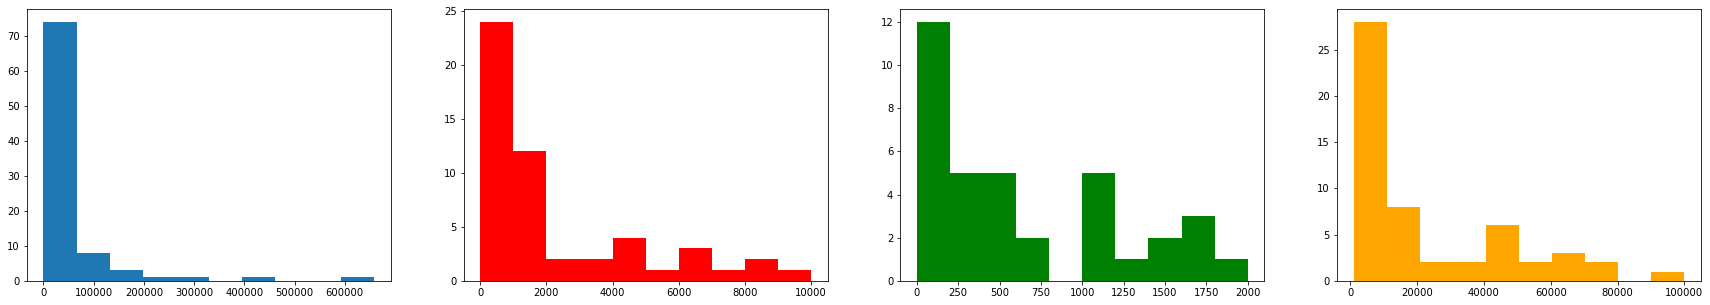

In [4]:
fig, axs = plt.subplots(1, 4, figsize = (30,5))
axs[0].hist(counts)
axs[1].hist(counts, range = [0, 10000], color = "red")
axs[2].hist(counts, range = [0, 2000], color = "green")
axs[3].hist(counts, range = [1000, 100000], color = "orange") # area of interest

Vengono convertiti tutti i dati, da Object a Float (Hold e Latency), Int (BirthYear), Boolean (Gender e Parkinsons) per poter effettuare calcoli sui valori delle feature.

In [4]:
# convert and normalize

all_userdata_df.Hold = all_userdata_df.Hold.astype(float)

all_userdata_df.Latency = all_userdata_df.Latency.astype(float)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in terms of ages

all_userdata_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)

In [5]:
all_userdata_df.head()

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158456,0QAZFRHQHW,L,93.8,LL,742.2,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0


#### Individuazione e rimozione degli outliers
Ci sono valori anomali delle feature Hold e Latency. Questi vengono rimossi, mantenendo i punti che hanno un valore di deviazione standard inferiore a 3.

In [7]:
hold_z_scores = stats.zscore(all_userdata_df["Hold"])
abs_z_scores = np.abs(hold_z_scores)
filtered_entries = (abs_z_scores < 3)
all_userdata_df = all_userdata_df[filtered_entries]

lat_z_scores = stats.zscore(all_userdata_df["Latency"])
abs_z_scores = np.abs(lat_z_scores)
filtered_entries2 = (abs_z_scores < 3)
all_userdata_df = all_userdata_df[filtered_entries2]

all_userdata_df.head()

,Users,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,0QAZFRHQHW,L,78.1,LL,312.5,58,0,0
158454,0QAZFRHQHW,L,78.1,LL,453.1,58,0,0
158455,0QAZFRHQHW,L,62.5,LL,414.1,58,0,0
158457,0QAZFRHQHW,R,101.6,LR,523.4,58,0,0
158458,0QAZFRHQHW,R,93.8,RR,203.1,58,0,0


Calcolo delle feature spiegate sopra.
I due dataset ottenuti vengono concatenati per ottenere *combined_df*.

In [8]:
hold_by_user =  all_userdata_df[all_userdata_df['TapPosition'] != 'S'].groupby(['Users', 'TapPosition'])['Hold'].agg([np.mean, np.std, skew, kurtosis])
hold_by_user.head()

mean        std      skew    kurtosis
Users      TapPosition                                             
0QAZFRHQHW L             98.240728  23.645192  0.162026    0.809259
           R            100.893509  36.764586  8.381640  126.796559
1XNJCXS3EY L            153.702407  53.213749  0.264109    0.605739
           R            105.622423  27.036622  2.790381   23.913747
3DIXPRIOSW L            147.733913  48.299987  0.705847    0.625965

In [9]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']
hold_by_user_flat.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff
Users,,,,,,,,,
0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984
3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175
5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043


In [11]:
latency_by_user = all_userdata_df[np.isin(all_userdata_df['Movement'], ['LL', 'LR', 'RL', 'RR'])].groupby(['Users', 'Movement'])['Latency'].agg([np.mean, np.std, skew, kurtosis])
latency_by_user.head()

mean         std      skew  kurtosis
Users      Movement                                            
0QAZFRHQHW LL        381.513699  138.685633  0.100358 -0.852940
           LR        370.189302  166.356770  0.199686 -1.147631
           RL        385.640196  143.653008  0.127575 -1.000993
           RR        344.055417  132.589072  0.328537 -0.522270
1XNJCXS3EY LL        347.882547  101.977747 -1.332784  1.946994

In [12]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']
latency_by_user_flat.head()

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
Users,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,381.513699,370.189302,385.640196,344.055417,138.685633,166.356770,143.653008,132.589072,0.100358,0.199686,0.127575,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282
1XNJCXS3EY,347.882547,313.541489,310.799454,322.170833,101.977747,97.680669,98.038127,82.901327,-1.332784,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714
3DIXPRIOSW,486.421516,496.948684,458.456098,454.361497,110.525337,114.504608,108.730466,138.325691,-0.654455,-0.070632,0.172017,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019
48DZPAJ5NS,300.190663,335.274126,321.053098,332.504906,81.809939,81.450453,88.512695,90.989458,0.361579,0.020670,0.143658,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242
5PQVTWULAC,347.886933,461.184922,429.867896,369.359147,105.043167,114.216291,110.960993,121.075534,0.471543,-0.290666,-0.029059,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215


In [13]:
combined_df = pd.concat([hold_by_user_flat, latency_by_user_flat], axis = 1)
combined_df.shape

(48, 27)

*all_userdata_df* e *combined_df* vengono uniti per creare *complete_df*, costituito da tutti i valori statistici calcolati per le vecchie feature TapPosition e Movement, oltre alle feature Age, Gender e Parkinsons.

In [14]:
all_userdata_df = all_userdata_df.drop(["TapPosition", "Hold", "Latency", "Movement"], axis=1)
all_userdata_df = all_userdata_df.drop_duplicates()

complete_df = combined_df.merge(all_userdata_df, how='left', left_on = 'Users', right_on = 'Users')
complete_df.head()

,Users,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
0,0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781,...,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282,58,0,0
1,1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
2,3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244,...,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019,81,1,0
3,48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
4,5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043,...,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215,74,0,1


##### Istogrammi per *complete_df*
Tutte le feature vengono graficate con i seguenti istogrammi.

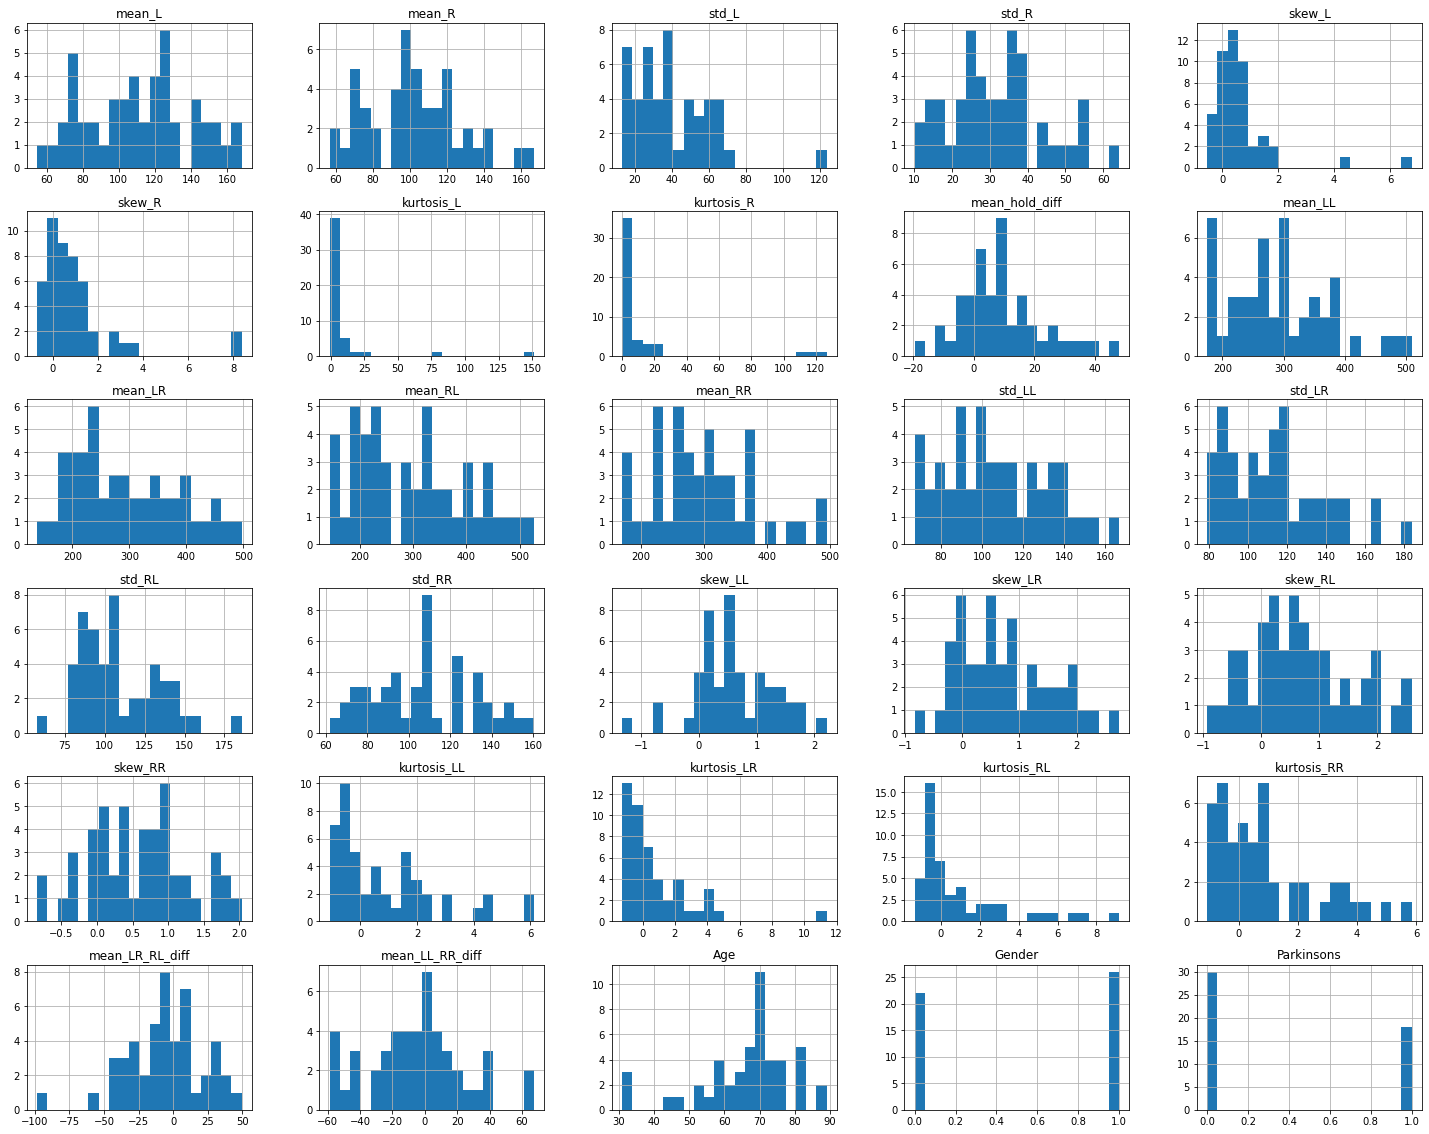

In [15]:
complete_df.hist(bins=20, figsize=(25, 20))
plt.show()

Pie plot per i pazienti con e senza morbo di Parkinson.

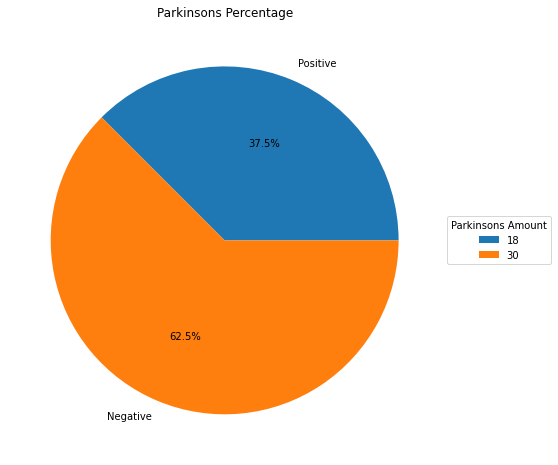

In [16]:
total_rows = complete_df.shape
counts_parkinson = complete_df[complete_df["Parkinsons"] == 1].shape

x = np.array([counts_parkinson[0], total_rows[0]-counts_parkinson[0]])
label = ["Positive", "Negative"]
plt.figure(figsize=(8,8), facecolor = "white")

plt.pie(x, labels = label, autopct='%1.1f%%')
plt.title("Parkinsons Percentage")
plt.legend(x, title="Parkinsons Amount", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Il dataset è leggermente sbilanciato, con una quantità maggiore di pazienti negativi. Per questo verrà effettuato un oversampling attraverso l'utilizzo della tecnica SMOTE.

In [17]:
complete_df.set_index('Users', inplace = True)

complete_df.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Age,Gender,Parkinsons
Users,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.240728,100.893509,23.645192,36.764586,0.162026,8.381640,0.809259,126.796559,-2.652781,381.513699,...,0.328537,-0.852940,-1.147631,-1.000993,-0.522270,-15.450894,37.458282,58,0,0
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,81,1,0
3DIXPRIOSW,147.733913,167.174157,48.299987,56.074955,0.705847,0.015762,0.625965,0.243456,-19.440244,486.421516,...,-0.842368,0.702029,-1.162515,-0.750796,0.818784,38.492587,32.060019,81,1,0
48DZPAJ5NS,125.093648,125.944823,21.344768,20.440962,0.433347,0.122130,5.116874,5.692705,-0.851175,300.190663,...,-0.052046,-0.565283,-0.705773,-0.929929,-1.042327,14.221029,-32.314242,67,1,1
5PQVTWULAC,131.600807,113.511765,37.119034,28.851806,0.968724,-0.031928,7.255120,0.777919,18.089043,347.886933,...,0.348485,1.542700,-0.364315,0.016987,0.084734,31.317026,-21.472215,74,0,1


### Preprocessing

#### Train e test
Si suddividono tutte le feature dal target, rappresentato dall'attributo Parkinsons.
Poi divido la matrice x e l'array y in sottoinsiemi casuali sfruttando la funzione *train_test_split*.

In [18]:
x = complete_df.iloc[:, :-1].values
y = complete_df.iloc[:, -1].values  # Parkinsons column

print(x)
print(y)

# split x matrix and y array in random train and test subsets, with ratio 3/4 - 1/4
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

[[ 98.2407279  100.89350913  23.64519173 ...  37.45828196  58.
    0.        ]
 [153.702407   105.62242315  53.21374903 ...  25.71171384  81.
    1.        ]
 [147.73391304 167.1741573   48.29998681 ...  32.06001857  81.
    1.        ]
 ...
 [101.62638772 113.74829833  44.00769261 ...  12.41033032  69.
    1.        ]
 [146.04592179 143.39524618  35.36990282 ... -25.67312141  89.
    1.        ]
 [131.02282292 122.02921979  64.96298389 ... -27.01565622  70.
    0.        ]]
[0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 1 0 1 0 0 0 1]


#### Scaling

Scalare i dati serve a migliorare il comportamento degli algoritmi di learning, dal momento che i dati potrebbero avere valori di tipi diversi tra loro. Valori troppo grandi possono comportarsi da outlier e stravolgere il funzionamento di un algoritmo.

Per scalare i dati si utilizza la normalizzazione attraverso lo *StandardScaler* offerto da sklearn, che normalizza le feature rimuovendo la media e scalando a varianza unitaria.

Il valore normalizzato di x è calcolato come: $$x = \frac{z-u}{S}$$

In [19]:
# scaling before classification models
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
# x_graph = scaler.fit_transform(x_graph)

#### Bilanciamento
Come già detto, il dataset risulta sbilanciato rispetto al target: il 62.5% delle osservazioni sono etichettate con 0 ('Negativo') mentre il 37.5% con 1 ('Positivo').

SMOTE (Synthetic Minority Oversampling Technique): serve ad aumentare la dimensione della classe minoritaria creando dati sintetici, creati in base a formule e algoritmi di clustering sui dati presenti.

In [20]:
smote = SMOTE(random_state=0, sampling_strategy='not majority', k_neighbors=5, n_jobs=-1)

x_train, y_train = smote.fit_resample(x_train, y_train)
print(x_train.shape, y_train.shape)
print(x_train)

(42, 29) (42,)
[[-1.50812386 -1.38540073 -1.15851515 ... -0.43267143  0.44993677
   0.89442719]
 [ 0.61643693 -0.35814141  3.75920391 ... -0.12550064  0.52036165
   0.89442719]
 [ 1.80735646  1.97835169  0.32720373 ... -0.10518222 -0.60643651
   0.89442719]
 ...
 [ 1.37554694  1.40550686  0.95594769 ...  1.45680472  0.29311098
   0.78029453]
 [ 1.06869355  1.05327912  0.86490828 ...  1.12721465  0.23227984
   0.34571698]
 [ 0.58495638  0.45160209  0.3094162  ...  0.25942947  0.06417283
  -0.15675148]]


##### Istogramma che confronta utenti con e senza il morbo di Parkinson

[0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1
 1 1 1 1 1]


(array([21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 21.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

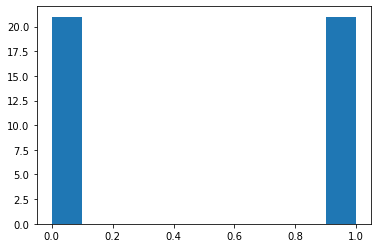

In [21]:
# verify that the classes are balanced
print(y_train)
np.histogram(y_train)
plt.hist(y_train)

### Classificazione

#### Naive Bayes

0.7380952380952381
0.5833333333333334


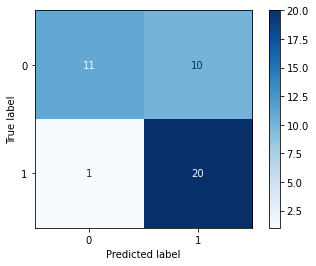

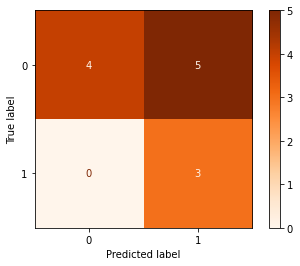

In [32]:
classifierBAYES = GaussianNB()
classifierBAYES.fit(x_train, y_train)

#The algorithm has learnt on training set, now I will predict the outcomes on test set

y_pred_BAYES0 = classifierBAYES.predict(x_train)
y_pred_BAYES = classifierBAYES.predict(x_test)

CM_BAYES0 = confusion_matrix(y_train, y_pred_BAYES0)
PercBAYES0 = (CM_BAYES0[0,0]+CM_BAYES0[1,1])/CM_BAYES0.sum()

CM_BAYES = confusion_matrix(y_test, y_pred_BAYES)
PercBAYES = (CM_BAYES[0,0]+CM_BAYES[1,1])/CM_BAYES.sum()

# each row of the confusion matrix is an instance of the true class
# matrix indicates true/false positive/negatives

cmd0 = ConfusionMatrixDisplay(CM_BAYES0)
cmd = ConfusionMatrixDisplay(CM_BAYES)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercBAYES0)
print(PercBAYES)

#### Logistic Regression

0.8809523809523809
0.75


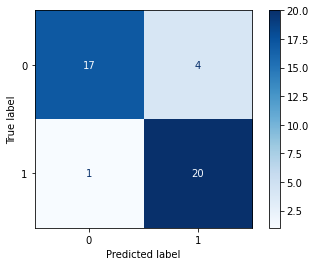

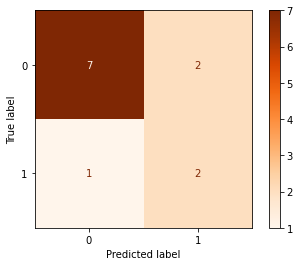

In [23]:
classifierLogReg = LogisticRegression(random_state = 0)
classifierLogReg.fit(x_train, y_train)

y_pred_LogReg0 = classifierLogReg.predict(x_train)
y_pred_LogReg = classifierLogReg.predict(x_test)

CM_LogReg0 = confusion_matrix(y_train, y_pred_LogReg0)
PercLogReg0 = (CM_LogReg0[0,0]+CM_LogReg0[1,1])/CM_LogReg0.sum()

CM_LogReg = confusion_matrix(y_test, y_pred_LogReg)
PercLogReg = (CM_LogReg[0,0]+CM_LogReg[1,1])/CM_LogReg.sum()

cmd0 = ConfusionMatrixDisplay(CM_LogReg0)
cmd = ConfusionMatrixDisplay(CM_LogReg)

cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercLogReg0)
print(PercLogReg)

#### Decision Tree
Il classificatore utilizzato è stato impostato con un criterio di misura della qualità dello split basato su _entropy_, una strategia _best_ di scelta dello split a ogni nodo (invece che random), e una profondità massima di 5, dal momento che questo valore è risultato il giusto compromesso tra complessità, velocità d'esecuzione e qualità di classificazione.

1.0
0.5


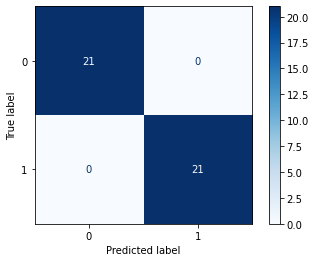

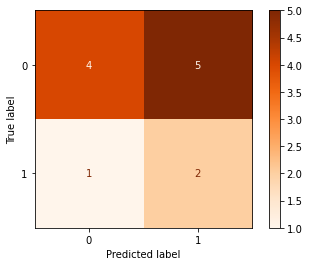

In [24]:
classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)

#### Random Forest
Così come nei decision tree, la scelta del criterio di valutazione della qualità dello split è ricaduta su _entropy_, mentre il numero di stimatori è stato impostato a 10, dal momento che si è notato che per valori più elevati i risultati rimanevano pressoché invariati.

1.0
0.9166666666666666


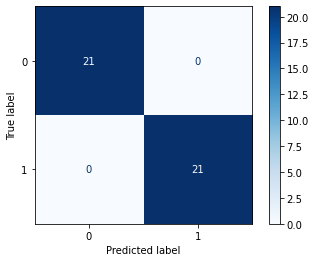

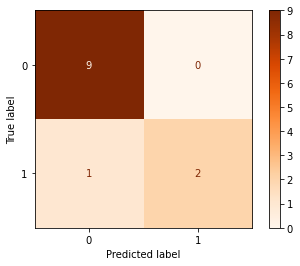

In [25]:
classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

#### Multiple Layer Perceptron
Nella cella successiva è presente l'implementazione di una rete neurale elementare, con 3 layer di 10 percettroni ciascuno, e una funzione di attivazione di tipo relu.

Questi valori dei paramentri sono sembrati i più adatti dopo diverse sperimentazioni.

0.8809523809523809
0.5833333333333334


c:\Users\tagli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


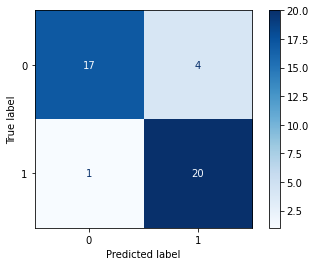

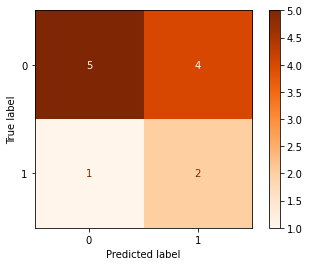

In [26]:
classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "relu", max_iter=50)         # relu act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "tanh", max_iter=50)         # tanh act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "identity", max_iter=50)     # identity act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "logistic", max_iter=50)     # logistic act

classifierMLPr.fit(x_train, y_train)

y_pred_MLPr0 = classifierMLPr.predict(x_train)
y_pred_MLPr = classifierMLPr.predict(x_test)

CM_MLPr0 = confusion_matrix(y_train, y_pred_MLPr0)
PercMLPr0 = (CM_MLPr0[0,0] + CM_MLPr0[1,1])/CM_MLPr0.sum()

CM_MLPr = confusion_matrix(y_test, y_pred_MLPr)
PercMLPr = (CM_MLPr[0,0] + CM_MLPr[1,1])/CM_MLPr.sum()

cmd0 = ConfusionMatrixDisplay(CM_MLPr0)
cmd = ConfusionMatrixDisplay(CM_MLPr)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercMLPr0)
print(PercMLPr)

#### Adaboost

In questa implementazione di Adaboost abbiamo usato la funzione _GridSearchCV_, che prende in input delle liste di parametri ed effettua una k-fold cross validation per l'addestramento con ogni singola combinazione dei parametri passati, per poi comunicare il risultato migliore e con quale configurazione è stato ottenuto.

In particolare i parametri immessi in _GridSearchCV_ sono: una lista di numero di stimatori, una lista di learning rate da utilizzare, il numero di fold in cui splittare il training set e il numero di ripetizioni da effettuare.

Infine, l'_AdaBoostClassifier_ utilizzato è quello di default, ovvero un decision tree con profondità 1 (ovvero uno stump).

In [27]:
classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [.001, .01, .1, 1]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')

# execute the grid search
grid_result = grid_search.fit(x_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.651667 using {'learning_rate': 1, 'n_estimators': 200}
0.470000 (0.169607) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.628333 (0.217057) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.625000 (0.209265) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.651667 (0.190824) with: {'learning_rate': 1, 'n_estimators': 200}


#### SVM 
La funzione kernel utilizzata è la radial basis function

0.8571428571428571
0.6666666666666666


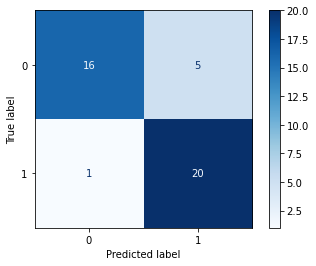

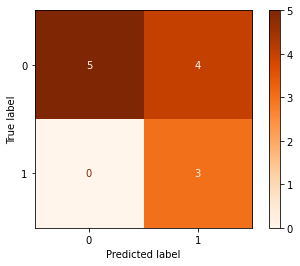

In [28]:
classifierSVC = SVC(kernel = 'rbf', random_state = 0)
classifierSVC.fit(x_train, y_train)

y_pred_SVMK0 = classifierSVC.predict(x_train)
y_pred_SVMK = classifierSVC.predict(x_test)

CM_SVMK0 = confusion_matrix(y_train, y_pred_SVMK0)
PercSVMK0 = (CM_SVMK0[0,0]+CM_SVMK0[1,1])/CM_SVMK0.sum()

CM_SVMK = confusion_matrix(y_test, y_pred_SVMK)
PercSVMK = (CM_SVMK[0,0]+CM_SVMK[1,1])/CM_SVMK.sum()

cmd0 = ConfusionMatrixDisplay(CM_SVMK0)
cmd = ConfusionMatrixDisplay(CM_SVMK)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercSVMK0)
print(PercSVMK)

#### K-Nearest Neighbors
Nella seguente implementazione dell'algoritmo KNN è stata utlizzata la metrica di Minkowski con paramentro p uguale a 2, che è sostanzialmente la distanza euclidea dei punti.

0.6904761904761905
0.6666666666666666


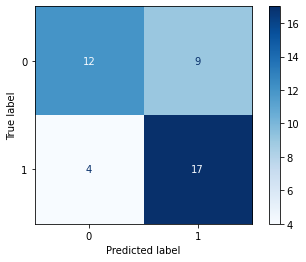

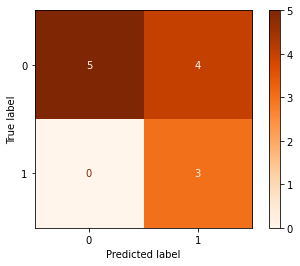

In [30]:
classifierKNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierKNN.fit(x_train, y_train)

y_pred_KNN0 = classifierKNN.predict(x_train)
y_pred_KNN = classifierKNN.predict(x_test)

CM_KNN0 = confusion_matrix(y_train, y_pred_KNN0)
PercKNN0 = (CM_KNN0[0,0]+CM_KNN0[1,1])/CM_KNN0.sum()

CM_KNN = confusion_matrix(y_test, y_pred_KNN)
PercKNN = (CM_KNN[0,0]+CM_KNN[1,1])/CM_KNN.sum()

cmd0 = ConfusionMatrixDisplay(CM_KNN0)
cmd = ConfusionMatrixDisplay(CM_KNN)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercKNN0)
print(PercKNN)

#### Ensemble Voting
Come ultimo algoritmo vengono messi insieme classificatori differenti seguendo il paradigma secondo cui la predizione è la _votazione_ di un comitato di decisori.

0.8571428571428571
0.6666666666666666


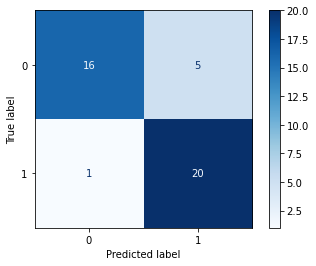

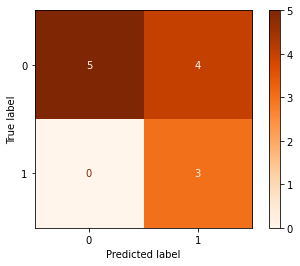

In [31]:
Models = []
Models.append(('KNN', classifierKNN))
Models.append(('SVC', classifierSVC))
Models.append(('Tree', classifierTREE))
# Models.append(('Logistic', classifierLogReg))
# Models.append(('Bayes', classifierBAYES))

# by removing these last two classifiers, performances increase

ensemble = VotingClassifier(Models)
ensemble = ensemble.fit(x_train, y_train)

y_pred_ENS0 = ensemble.predict(x_train)
y_pred_ENS = ensemble.predict(x_test)

CM_ENS0 = confusion_matrix(y_train, y_pred_ENS0)
PercENS0 = (CM_ENS0[0,0]+CM_ENS0[1,1])/CM_ENS0.sum()

CM_ENS = confusion_matrix(y_test, y_pred_ENS)
PercENS = (CM_ENS[0,0]+CM_ENS[1,1])/CM_ENS.sum()

cmd0 = ConfusionMatrixDisplay(CM_ENS0)
cmd = ConfusionMatrixDisplay(CM_ENS)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercENS0)
print(PercENS)

### Considerazioni v2
Alla fine di questa seconda versione ci si è accorti immediatamente che i risultati di classificazione erano molto più scadenti della precedente: l'aggregazione di dati effettuata è stata probabilmente troppo elevata, e si è persa una gran parte di informazione. Quest'ultima asserzione è provata dal fatto che stavolta il dataset a disposizione era enormemente più piccolo del precedente.